In [1]:
#MCMC FIT TO HST DATA INCLUDING BOTH ERI II AND CLUSTER, BINNED BY 30 PIXELS, AND MASKED 
#APPROPRIATELY
#PLUMMER PROFILE FOR ERI II, SERSIC PROFILE FOR CLUSTER
#UPDATED TO FIT ALL MODEL PARAMETERS INSTEAD OF JUST RICHNESS AND CENTER POSITION
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
# from matplotlib.mlab import rec2csv

import emcee
import corner

# from astropy.io import ascii
import _pickle as cPickle

In [2]:
cat = np.genfromtxt('/Volumes/Spare Data/photRun0520/drcPhot10Nov/catDir_PEGASUS-III/PEGASUS-III_matchedDRCfilt.dat',
                    names=True)


In [53]:
good = np.logical_and(cat['magr_f606w']<=27,np.logical_or(cat['six_4_flag_f606w'] == 1,
                       cat['six_4_flag_f814w'] == 1))

In [54]:
xgood = cat['xcenter_f606w'][good]
ygood = cat['ycenter_f606w'][good]

In [55]:
len(xgood)

401

In [7]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA

IMAGE = Path([ [222, 4043], 
	[1, 1], 
	[4096, 101], 
	[4217, 4245], 
	[222, 4043]])

GAP = Path([ [100, 2079], 
	[106, 2034], 
	[4156, 2183], 
	[4151, 2231], 
	[100, 2079]])



IMG_BIT = 0b01
GAP_BIT = 0b10

In [8]:
print(min(xgood))
print(max(xgood))

print(min(ygood))
print(max(ygood))

133.96352701468157
4197.885192410642
34.49456612918585
4227.2546755537005


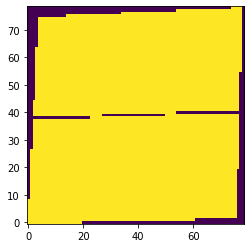

In [9]:
#DEFINE A GRID OF 30X30 PIXEL BINS COVERING THE IMAGE
NBINS = 80
XMIN,XMAX = 0,4260
YMIN,YMAX = 0,4260
XEDGE = np.linspace(XMIN,XMAX,NBINS)
YEDGE = np.linspace(XMIN,XMAX,NBINS)

#BIN CENTERS
XCENT = (XEDGE[1:] + XEDGE[:-1])/2.
YCENT = (YEDGE[1:] + YEDGE[:-1])/2.
#BIN SIZE
XDEL = XEDGE[1]-XEDGE[0]
YDEL = YEDGE[1]-YEDGE[0]

# Pre-calculate these instead of doing it in each evaluation of the model...
XX,YY= np.meshgrid(XCENT,YCENT,indexing='ij')


#USE THE MASKED REGIONS FROM ABOVE TO CREATE AN IMAGE MASK WITH THE APPROPRIATE BINNING
#REQUIRES FLATTENING THE ARRAYS
MASK = np.zeros((NBINS-1,NBINS-1))
image_mask = IMAGE.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
gap_mask = GAP.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
plt.imshow(MASK.T,origin='lower')

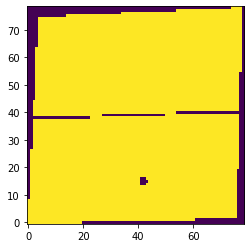

In [10]:
#ADD HIGHLY SATURATED STAR IN THE WEST TO MASK
satstar_xcen = 2267
satstar_ycen = 813
near_satstar = np.where( np.sqrt((XX - satstar_xcen)**2 + (YY - satstar_ycen)**2) < 84)

DIFF_SPIKES_EW = Path([ [1862, 829], 
	[1862, 823], 
	[2640, 823], 
	[2640, 829], 
	[1862, 829]])

DIFF_SPIKES_NS = Path([ [2263, 1183], 
    [2250, 501], 
	[2264, 492], 
	[2276, 1178], 
	[2263, 1183]])

MASK[near_satstar] = 0

spikes_mask_ew = DIFF_SPIKES_EW.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_spikes_ew = np.where(spikes_mask_ew==1) # Array indices
MASK[masked_indices_spikes_ew] = 0

spikes_mask_ns = DIFF_SPIKES_NS.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_spikes_ns = np.where(spikes_mask_ns==1) # Array indices
MASK[masked_indices_spikes_ns] = 0
plt.imshow(MASK.T,origin='lower')

In [30]:
#DEFINE INITIAL MODEL PARAMETERS FOR peg3 II
peg3_NSTAR = 1000 
#peg3_LON = 56.0888               # RA (deg)
#peg3_LAT = -43.5304              # Dec (deg)
peg3_X0 = 2900                   # X Center (pix)
peg3_Y0 = 2200                   # Y Center (pix)
peg3_EXT = 1.3/60.               # Extension (deg) # radius in arcminutes
peg3_EXT_PIX = peg3_EXT*(3600/0.05)              # Extension (pix)
peg3_ELL = 0.2                 # Ellipticity
peg3_PA = 130              # Position angle (deg)
peg3_BG = 1

In [31]:
peg3_EXT_PIX

1560.0

In [32]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [33]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[XEDGE,YEDGE])
    return data_counts

In [34]:
def new_kernel(x,y,lon=peg3_X0,lat=peg3_Y0,ext=peg3_EXT_PIX,ell=peg3_ELL,pa=peg3_PA):
    """ Evaluate the elliptical exponential kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)

    return pdf

In [35]:
def new_kernel_plummer(x,y,lon=peg3_X0,lat=peg3_Y0,ext=peg3_EXT_PIX,ell=peg3_ELL,pa=peg3_PA):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [36]:
def model(theta_peg3):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_peg3[0]
    kwargs = dict(lon=theta_peg3[1],lat=theta_peg3[2],ext=theta_peg3[3],ell=theta_peg3[4],pa=theta_peg3[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    sigma_bg = theta_peg3[6]
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel_plummer(XX,YY,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = XDEL*YDEL
    model_counts = richness * pdf * pixarea + sigma_bg
    return model_counts

In [37]:
def lnlike(theta, x, y):
    """ Likelihood function
    Parameters
    ----------
    theta : model parameter array (richness,lon,lat,ext,ell,pa)x2
    x: x-coordinate of data
    y: y-coordinate of data
    
    Returns
    -------
    lnlike: log-likelihood
    """

    #BREAK THETA UP INTO ERI II AND CLUSTER COMPONENTS
    #IF ONLY ONE COMPONENT IS BEING FIT, THEN THESE LINES ARE NOT NEEDED
    theta_peg3 = theta
    
    #commenting out to see if this will run
#     theta_cluster = theta[6:]
    
    # Calculate the data counts and model predicted counts in each pixel bin
    data_counts = data(x,y)
    model_counts_peg3 = model(theta_peg3)
    
    #ditto
#     model_counts_cluster = model_cluster(theta_cluster)
    #TO FIT A SINGLE COMPONENT, USE, E.G., MODEL_COUNTS = MODEL_COUNTS_peg3
    model_counts = model_counts_peg3 #+ model_counts_cluster

    # Apply the mask to the data and model. This selects only pixels
    # in the image for calculating the likelihood.
    data_counts_masked = data_counts[IDX]
    model_counts_masked = model_counts[IDX]
    
    # Evaluate Equation C2 from Drlica-Wagner et al. 2020 (1912.03302; ignore k! term)
    lnlike = np.sum(-model_counts_masked + data_counts_masked * np.log(model_counts_masked))
    return lnlike

In [38]:
def lnprior(theta):
    """ The log-prior. Add whatever you want here... 
    
    Parameters
    ----------
    theta : model parameters

    Returns
    -------
    lnprior : log-prior
    """
    #PRIORS FOR EACH FITTED PARAMETER
    #TO REMOVE ANY PARAMETER FROM THE FIT, REMOVE IT FROM THE LINE BELOW AND ELIMINATE THE CONSTRAINT FOR IT
    
    rich1,lon1,lat1,ext1,ell1,pa1,bg1 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6]

    if not (100 < rich1 < 10000):  return np.inf
    if not (0 < lon1 < 5000): return np.inf
    if not (500 < lat1 < 5000): return np.inf
    if not (500 < ext1 < 10000): return np.inf
    if not (0.1 < ell1 < 0.9): return np.inf
    if not (120 < pa1 < 200): return np.inf
    if not (0 < bg1 < 1000): return np.inf

    return 0

In [39]:
def lnprob(theta, x, y):
    """ The log-probability = lnlike + lnprob 

    Parameters
    ----------
    theta : the model parameter vector
    x     : x-coord of the data
    y     : y-coord of the data
    
    Returns
    -------
    lnprob : log-probability
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Running mcmc...


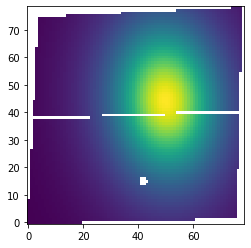

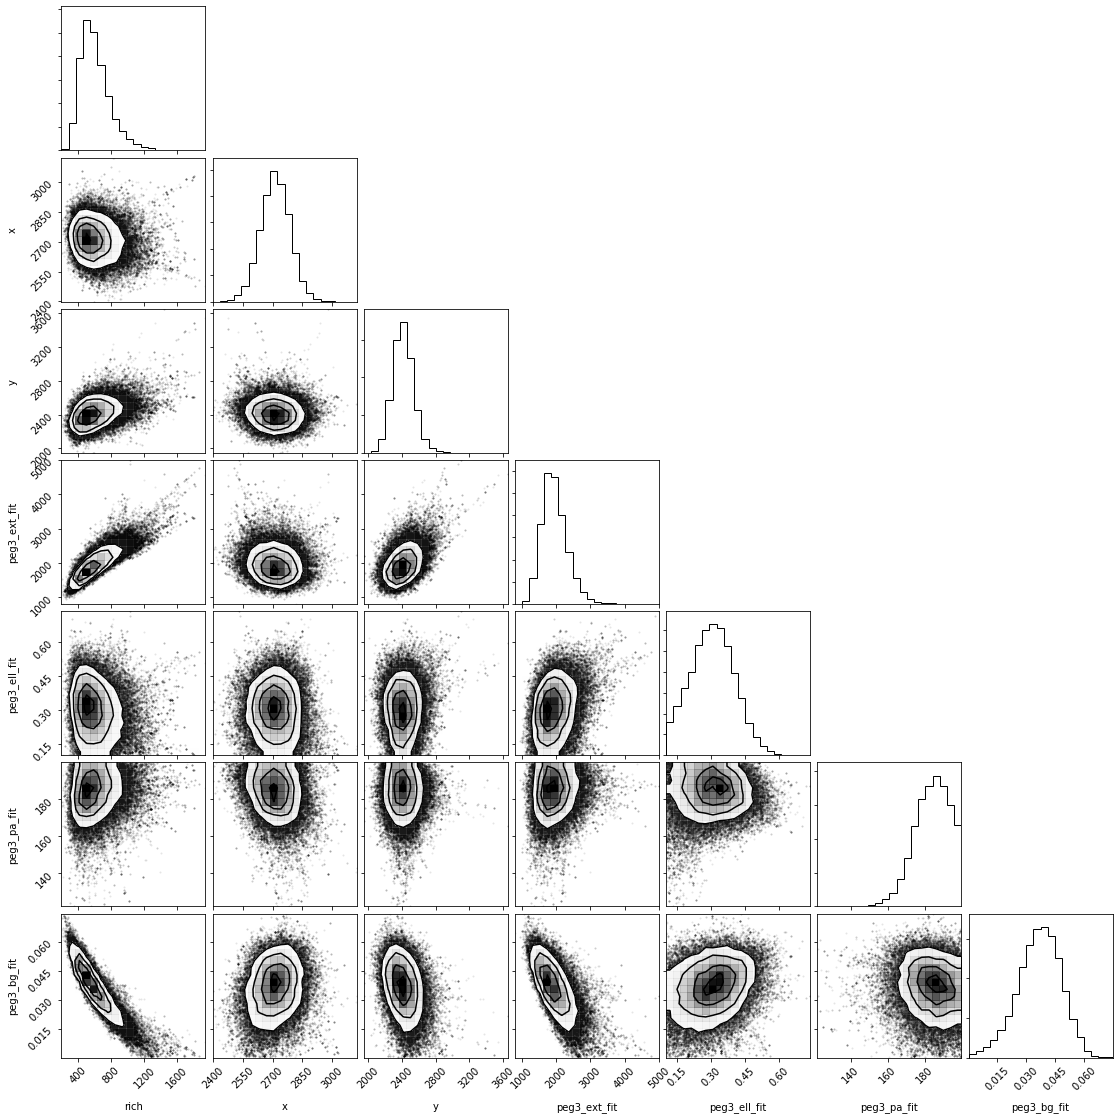

In [41]:
#FLAG FOR DISPLAYING PLOTS
do_plot=True
save_plot=True

#SET INITIAL GUESSES FOR PARAMETERS (ANY PARAMETERS NOT BEING FIT SHOULD BE REMOVED HERE)
THETA = [peg3_NSTAR,peg3_X0,peg3_Y0,peg3_EXT_PIX,peg3_ELL,peg3_PA,peg3_BG]


#PLOT (MASKED, BINNED) OBSERVED SURFACE DENSITY
if do_plot:
    # Example of the masked counts and data
    # (transpose due to difference between imshow and histogram2d...)
    data_counts = data(xgood,ygood)
    data_counts_masked = np.copy(data_counts)
    data_counts_masked[np.where(MASK==0)] = np.nan
#     out_masked_counts = data_counts_masked
    plt.imshow(data_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('data_counts_maskedPeg3_pa3.png')
     
# Initialize and run the mcmc
print("Running mcmc...")
ndim, nwalkers = len(THETA), 100
nthreads,nsamples = 16, 2000
nburn = 750
pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
     
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(xgood,ygood),
                                threads=nthreads)
sampler.run_mcmc(pos,nsamples)
     
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
peg3_ext_fit,[peg3_ext_min,peg3_ext_max] = median_interval(samples[:,3])
peg3_ell_fit,[peg3_ell_min,peg3_ell_max] = median_interval(samples[:,4])
peg3_pa_fit,[peg3_pa_min,peg3_pa_max] = median_interval(samples[:,5])
peg3_bg_fit,[peg3_bg_min,peg3_bg_max] = median_interval(samples[:,6])



if do_plot:
    theta_peg3 = [rich,x,y,peg3_ext_fit,peg3_ell_fit,peg3_pa_fit,peg3_bg_fit]
    model_counts_peg3 = model(theta_peg3)
    model_counts = model_counts_peg3 
    model_counts_masked = np.copy(model_counts)
    model_counts_masked[np.where(MASK==0)] = np.nan
#PLOT (MASKED, BINNED) MODEL SURFACE DENSITY
    plt.imshow(model_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('model_counts_maskedPeg3_pa3.png')

#CORNER PLOT    
    fig = corner.corner(samples, labels=["rich", "x", "y", "peg3_ext_fit", "peg3_ell_fit", 
                                         "peg3_pa_fit","peg3_bg_fit"])
    if save_plot:
        fig.savefig("trianglePeg3_pa3.png")


In [42]:
conv = 0.05/60 # pix to arcmin

In [43]:
res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
       peg3_ext_fit*conv,peg3_ext_max*conv-peg3_ext_fit*conv,peg3_ext_fit*conv-peg3_ext_min*conv,
           peg3_ell_fit,peg3_ell_max-peg3_ell_fit,peg3_ell_fit-peg3_ell_min,
       peg3_pa_fit,peg3_pa_max-peg3_pa_fit,peg3_pa_fit-peg3_pa_min,
      peg3_bg_fit,peg3_bg_max-peg3_bg_fit,peg3_bg_fit-peg3_bg_min]

# print(res)

print('Rich:',rich,rich_max-rich,rich-rich_min)
print('X:',x,xmax-x,x-xmin)
print('Y:',y,ymax-y,y-ymin)
print('Ext (arcmin)',peg3_ext_fit*conv,peg3_ext_max*conv-peg3_ext_fit\
          *conv,peg3_ext_fit*conv-peg3_ext_min*conv)
print('Ell:',peg3_ell_fit,peg3_ell_max-peg3_ell_fit,peg3_ell_fit-peg3_ell_min)
print('PA:',peg3_pa_fit,peg3_pa_max-peg3_pa_fit,peg3_pa_fit-peg3_pa_min)
print('BG:',peg3_bg_fit,peg3_bg_max-peg3_bg_fit,peg3_bg_fit-peg3_bg_min)



Rich: 572.4245491995471 203.5381175408054 137.0259877588099
X: 2712.5545347675215 71.97900832484629 73.83305419834142
Y: 2408.427359036842 122.35781267332504 112.52362181549188
Ext (arcmin) 1.5846786557442996 0.32865803563398277 0.25862484713723544
Ell: 0.30302224167731584 0.0972975589554046 0.10060787586802991
PA: 184.59907620207255 9.223647237696298 10.410012667987075
BG: 0.03711826622232463 0.010490096839517904 0.011623833020267878


In [ ]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(0,80)
plt.ylim(0,80)
plt.clim(-2.5,2.5)